In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from plotly import __version__
import cufflinks as cf

from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [2]:
%matplotlib inline

# Loading in data

In [3]:
# Import hourly pickups by Chicago Side
df_sides = pd.read_csv("Hourly_pickups_by_sides_v1.csv")

# change to datetime object
df_sides["StartTime"] = pd.to_datetime(df_sides["StartTime"])

# set index
df_sides.set_index("StartTime", inplace=True)

df_sides.describe().astype(int)

,FNS,Ohara,NWS,NS,WS,CEN,SS,SWS,FSWS,FSES
count,10224,10224,10224,10224,10224,10224,10224,10224,10224,10224
mean,8,4,3,19,21,30,6,4,1,2
std,5,3,2,14,13,20,4,3,1,1
min,0,0,0,0,0,0,0,0,0,0
25%,5,1,1,10,11,13,3,3,0,1
50%,8,3,3,17,21,30,6,5,1,2
75%,12,6,5,27,30,45,10,7,2,3
max,39,23,16,100,85,122,28,22,8,15


In [4]:
# concert dataframe to floats
df_sides.astype(float)

,FNS,Ohara,NWS,NS,WS,CEN,SS,SWS,FSWS,FSES
StartTime,,,,,,,,,,
2018-11-01 00:00:00,6.0,1.0,2.0,17.0,9.0,20.0,8.0,1.0,0.0,0.0
2018-11-01 01:00:00,4.0,0.0,2.0,20.0,6.0,6.0,3.0,0.0,1.0,1.0
2018-11-01 02:00:00,5.0,0.0,1.0,7.0,8.0,13.0,0.0,2.0,2.0,1.0
2018-11-01 03:00:00,2.0,0.0,1.0,3.0,6.0,4.0,0.0,0.0,1.0,1.0
2018-11-01 04:00:00,3.0,0.0,1.0,5.0,5.0,5.0,2.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,27.0,2.0,5.0,59.0,54.0,63.0,6.0,4.0,5.0,1.0
2019-12-31 20:00:00,36.0,3.0,11.0,73.0,44.0,58.0,12.0,9.0,3.0,7.0
2019-12-31 21:00:00,30.0,3.0,8.0,66.0,40.0,74.0,15.0,7.0,2.0,2.0


# Time series check need for differencing

In [478]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [191]:
def get_stationarity(timeseries):
    # rolling statistics
    rolling_mean = timeseries.rolling(window=24).mean()
    rolling_std = timeseries.rolling(window=24).std()
    
    # rolling statistics plot
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(timeseries.index, timeseries, color="blue", label="Original")
    ax.plot(rolling_mean, color="red", label="Rolling Mean")
    ax.plot(rolling_std, color="black", label="Rolling Std")
    ax.legend(loc="best")
    ax.set_title("Rolling Mean & Standard Deviation")
    
    # Dickey-Fuller test:
    result = adfuller(timeseries)
    print("ADF Statistics: {}".format(result[0]))
    print("p-value: {}".format(result[1]))
    print("Critical Values:")
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))


In [192]:
df_ohara = df_sides.iloc[:, 1]

ADF Statistics: -11.766407365100614
p-value: 1.1163078008375174e-21
Critical Values:
	1%: -3.4309922139298674
	5%: -2.8618238209224707
	10%: -2.566921072734192


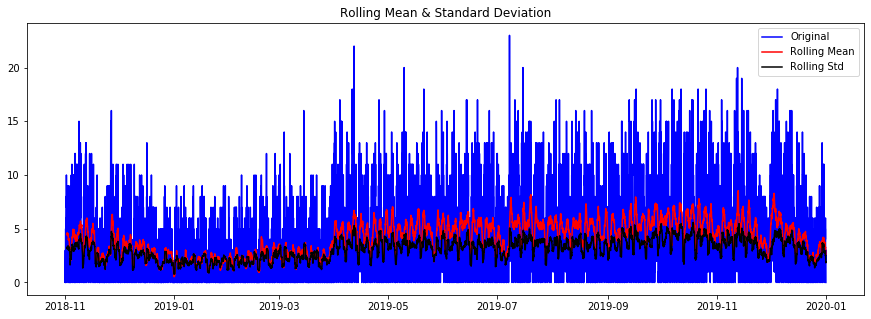

In [193]:
get_stationarity(df_ohara)

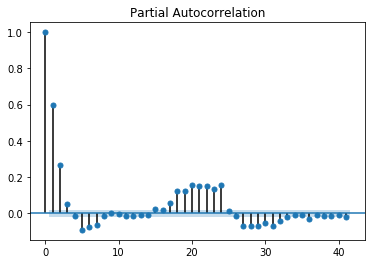

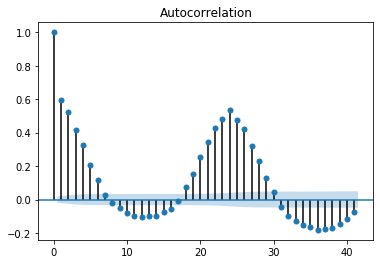

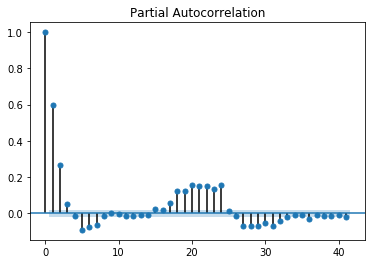

In [479]:
# get ACF and PACF plot
plot_acf(df_ohara)
plot_pacf(df_ohara)

In [222]:
# create a differenced series
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

# invert difference
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [223]:
transformed = difference(df_ohara, 1)

In [224]:
transformed
inverted = invert_difference(df_ohara, transformed, 1)

# Machine learning methods: XGBoost and LSTM

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.
/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version o

# Baseline model

This model serves as a baseline performance to which ARIMA, Holt-Winters, MLP, (XGBoost)?, and LSTM are compared to.

Gives idea of how well your models perform on the problem at hand.

Baseline has the following elements:
- dataset
- resampling technique used to estimate performance (e.g. train, test split)
- Performance measure to evaluate forecast

The persistence algorithm: use value at time (t) to predict (t+1)

Step 1: supervised learning problem

In [110]:
df_baseline = df_sides.iloc[:, 1]

In [111]:
# shift time series 
def shift_ts(df_ts):
    df_ts = pd.DataFrame(df_ts)
    df_ts["input"] = df_ts.shift(1)
    df_ts.fillna(0, inplace=True)
    return df_ts

In [112]:
df_baseline = shift_ts(df_baseline)

Step 2: train and test sets

In [124]:
def split_baseline_data(data):
    # set fractions
    train_size = int(len(data) * 0.8)
    test_size = len(data) - train_size
    
    # split data into train and test sets
    train = data[0:train_size]
    test = data[train_size:]
    
    # split train and test further into x_train, y_train, x_test, y_test
    x_train = train.iloc[:, 1]
    x_test = test.iloc[:, 1]

    y_train = train.iloc[:, 0]
    y_test = test.iloc[:, 0]
    
    # convert into numpy arrays
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # reshape to make numpy arrays into 2D
    x_train = x_train.reshape(-1,1)
    x_test = x_test.reshape(-1,1)
    y_train = y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1)
    
    return train, test, x_train, x_test, y_train, y_test

In [125]:
train, test, x_train, x_test, y_train, y_test = split_baseline_data(df_baseline)

In [126]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(8179, 1) (2045, 1) (8179, 1) (2045, 1)


Step 3: persistence algorithm

In [129]:
def model_persistence(x):
    return x

Step 4: make and evaluate forecast

Test MSE: 12.240


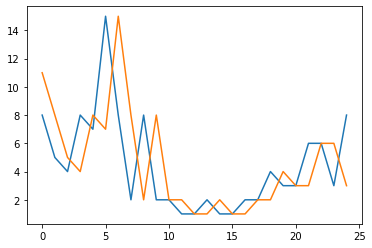

In [133]:
# walk-forward validation
predictions = list()
for x in x_test:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(y_test, predictions)
print('Test MSE: %.3f' % test_score)

plt.plot(y_test[500:525])
plt.plot(predictions[500:525])

# LSTM only past values as input

In [273]:
def ts_supervised(df, colnum):
    df_ts = df.iloc[:, colnum]
    df_ts = df_ts.astype(float)
    df_ts = pd.DataFrame(df_ts)
    df_ts["input"] = df_ts.shift(1)
    df_ts.fillna(0, inplace=True)
    return df_ts

In [242]:
supervised = ts_supervised(df_sides, colnum=1)


In [244]:
def split_data(data):
    # set fractions
    train_size = int(len(data) * 0.8)
    test_size = len(data) - train_size
    
    # split data into train and test sets
    train = data[0:train_size]
    test = data[train_size:]
    
    # split train and test further into x_train, y_train, x_test, y_test
    x_train = train.iloc[:, 1]
    x_test = test.iloc[:, 1]

    y_train = train.iloc[:, 0]
    y_test = test.iloc[:, 0]
    
    # convert into numpy arrays
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # reshape to make numpy arrays into 2D
    x_train = x_train.reshape(-1,1)
    x_test = x_test.reshape(-1,1)
    y_train = y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1)
    
    return train, test, x_train, x_test, y_train, y_test

In [245]:
train, test, x_train, x_test, y_train, y_test = split_data(supervised)

In [246]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(8179, 1) (2045, 1) (8179, 1) (2045, 1)


In [249]:
x_scaler, y_scaler, x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = scale(x_train, x_test, y_train, y_test)


In [250]:
print(x_train_scaled.shape, x_test_scaled.shape, y_train_scaled.shape, y_test_scaled.shape)

(8179, 1, 1) (2045, 1, 1) (8179, 1) (2045, 1)


# Long Short Term Memory RNN
# Model Architecture

The steps of creating a LSTM RNN are:
- Defining the model
- Adding layers
- Add compiling: define loss function, optimizer, and metrics.
- Training/fit the LSTM
- Evaluate performance
- Generate predictions

Model has layers:
- Model layer (LSTM): this is a recurrent layer comprised of memory units. Input shape needs to be 3D array. That is a tuple (tuple) of two values with the number of steps and features.
- Dense Layer: layer used to ouput a prediction.
- Compile Layers: is an efficiency step, transforming simple sequence of layers into a series for your GPU or CPU. Requires parameters 1) optimization algorithm to train the network and 2) loss function to evluatie the network by minimuzing the optimization algorithm (gradient descent)

Important info on hyperparameter tuning! 

You want to check different settings for one hyperparameter on the model performance at the time: ceterus paribus. Repeat same experiments and compare summary statistics for each configuration.

- Number of neurons affect learning capacity of network. Generally, more neurons = learning more the structure of the problem at cost of longer training time and potential overfitting.

In [251]:
x_train_scaled.shape

(8179, 1, 1)

In [252]:
x_train_scaled.shape[2]

1

In [262]:
def fit_lstm(x_train_scaled, y_train_scaled, batch, ep, neurons_lstm, neuron_dense):
    model = Sequential()
    model.add(LSTM(units=neurons_lstm, input_shape=(x_train_scaled.shape[1], x_train_scaled.shape[2])))
    model.add(Dense(units=neuron_dense))
    model.add(Dropout(rate=0.2))
    model.compile(loss="mean_squared_error", 
                  optimizer="adam",
                 )
    
    history = model.fit(x_train_scaled, 
                        y_train_scaled, 
                        epochs=ep, 
                        batch_size=batch, 
                        validation_split=0.1, 
                        verbose=1, 
                        shuffle=False)
    return model, history

In [263]:
model, history = fit_lstm(x_train_scaled, 
                          y_train_scaled, 
                          batch=10, ep=5, 
                          neurons_lstm=10, 
                          neuron_dense=1)

Train on 7361 samples, validate on 818 samples
Epoch 1/5
7361/7361 [==============================] - 2s 314us/step - loss: 0.0226 - val_loss: 0.0251
Epoch 2/5
7361/7361 [==============================] - 2s 221us/step - loss: 0.0204 - val_loss: 0.0240
Epoch 3/5
7361/7361 [==============================] - 2s 214us/step - loss: 0.0201 - val_loss: 0.0239
Epoch 4/5
7361/7361 [==============================] - 2s 213us/step - loss: 0.0207 - val_loss: 0.0240
Epoch 5/5
7361/7361 [==============================] - 2s 214us/step - loss: 0.0205 - val_loss: 0.0240


Text(0, 0.5, 'Loss')

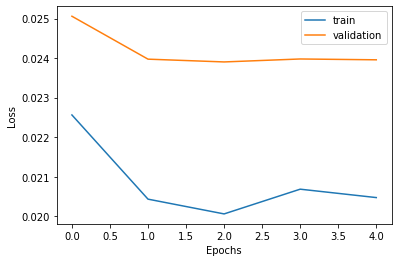

In [264]:
# Evaluate Network
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [265]:
def predictions(x_test_scaled, y_test):
    # get predictions
    test_pred = model.predict(x_test_scaled)
    
    # reverse transform predictions
    test_pred_inv = x_scaler.inverse_transform(test_pred)
    
    # create single dataframe with predictions (1) and expected values (2)
    predictions = np.concatenate((test_pred_inv, y_test), axis=1)
    predictions = pd.DataFrame(predictions)
    
    return predictions

In [266]:
predictions = predictions(x_test_scaled, y_test)

In [267]:
def evaluate_lstm(predictions, start_val, end_val):
    # print RMSE
    rmse = np.sqrt(mean_squared_error(predictions[0], predictions[1]))
    print('Test RMSE: %.3f' % rmse)
    
    # print min max values of predictions and actual values.
    print("Min. value:", predictions[0].min())
    print("Max. value:", predictions[0].max())

    print("Min. value:", predictions[1].min())
    print("Max. value:", predictions[1].max())
    
    # plot predictions vs actual values
    plt.plot(predictions[0][start_val:end_val])
    plt.plot(predictions[1][start_val:end_val])
    
    return rmse

Test RMSE: 3.355
Min. value: 1.595537543296814
Max. value: 9.69081974029541
Min. value: 0.0
Max. value: 20.0


3.355287510075308

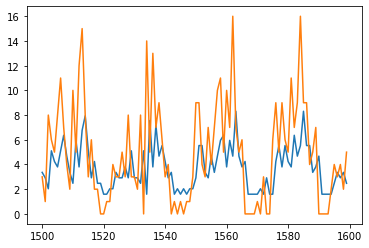

In [270]:
evaluate_lstm(predictions, start_val=1500, end_val=1600)

In [271]:
def check_min_max(ts1, ts2):
    if isinstance(ts1, pd.DataFrame) and isinstance(ts1, pd.DataFrame):
        print("Min value output value:", ts1.min())
        print("Max value input value:", ts1.max())
        print("Min value output value:", ts2.min())
        print("Max value ouput value:", ts2.max())
    elif isinstance(ts1, np.ndarray) and isinstance(ts2, np.ndarray):
        print("Min value input value:", np.min(ts1))
        print("Max value input value:", np.max(ts1))
        print("Min value output value:", np.min(ts2))
        print("Max value ouput value:", np.max(ts2))
    else:
        print("Error, not dataframe nor numpy array")

In [272]:
check_min_max(x_train, x_test)

Min value input value: 0.0
Max value input value: 23.0
Min value output value: 0.0
Max value ouput value: 20.0


# LSTM Multivariate demand prediction with weather data

We should add the weather data to the dataset. In other words, we are making a multivariate time series.

In [139]:
# Import hourly weather data

weather = pd.read_csv("Chicago Ohare hourly weather relevant data.csv")
weather["Date"] = pd.to_datetime(weather["Date"])
weather.drop("WeatherType", axis=1, inplace=True)
weather["Temperature"] = weather["Temperature"].astype("float32")
weather.set_index("Date", inplace=True)

In [140]:
weather.head()

,Precipitation,WindSpeed,Temperature
Date,,,
2018-11-01 00:00:00,0.0,9.66,9.0
2018-11-01 01:00:00,0.0,9.66,9.0
2018-11-01 02:00:00,0.0,9.66,9.0
2018-11-01 03:00:00,0.0,12.88,9.0
2018-11-01 04:00:00,0.0,16.10,9.0


In [141]:
df_ohara = pd.DataFrame(df_sides["Ohara"])
df_ohara.head()

,Ohara
StartTime,
2018-11-01 00:00:00,1
2018-11-01 01:00:00,0
2018-11-01 02:00:00,0
2018-11-01 03:00:00,0
2018-11-01 04:00:00,0


In [142]:
df_lstm = df_ohara.merge(weather, how="left", left_index=True, right_index=True)
df_lstm.astype("float32")
df_lstm.head(10)

,Ohara,Precipitation,WindSpeed,Temperature
StartTime,,,,
2018-11-01 00:00:00,1,0.0,9.66,9.0
2018-11-01 01:00:00,0,0.0,9.66,9.0
2018-11-01 02:00:00,0,0.0,9.66,9.0
2018-11-01 03:00:00,0,0.0,12.88,9.0
2018-11-01 04:00:00,0,0.0,16.10,9.0
2018-11-01 05:00:00,3,0.0,14.49,10.0
2018-11-01 06:00:00,0,0.0,16.10,10.0
2018-11-01 07:00:00,2,0.0,17.71,10.0
2018-11-01 08:00:00,4,0.0,16.10,10.0


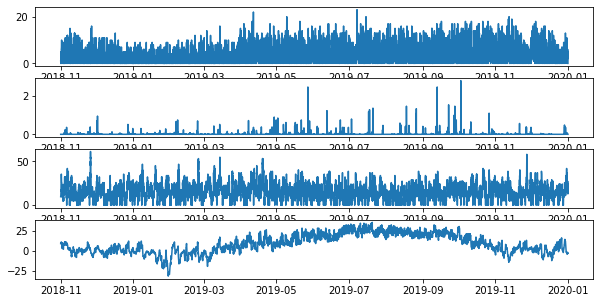

In [143]:
# plot hourly pickups with weather data.
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,5))
ax[0].plot(df_lstm["Ohara"])
ax[1].plot(df_lstm["Precipitation"])
ax[2].plot(df_lstm["WindSpeed"])
ax[3].plot(df_lstm["Temperature"])

# LSTM data preperation

Frame dataset as supervised learning problem and MinMaxScale the data

Try to predict ride hailing demand at hour (t) based on demand and weather data in period (t-1). Later try to predict based on past 24 hours (t-1 - t-24)

In [333]:
df_lstm.shape

(10224, 4)

In [480]:
# specify number of lag hours
n_hours = 7
n_features = 4
n_obs = n_hours * n_features

In [481]:
# from: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

def ts_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Split prepared dataset into train and test set

Get train and test sets, then split train and test sets into input and output variables. Then inputs (x_train and x_test) are reshaped to 3D format

In [482]:
# frame as supervised learning
supervised = ts_supervised(df_lstm, n_hours, 1)

In [483]:
# split function applied to one Chicago area with weather data
def split_data(data):
    # set fractions
    train_size = int(len(data) * 0.8)
    test_size = len(data) - train_size
    
    # split data into train and test sets
    train = data[0:train_size]
    test = data[train_size:]
    
    # split train and test further into x_train, y_train, x_test, y_test
    # when using multiple time steps
    x_train = train.iloc[:, :n_obs]
    x_test = test.iloc[:, :n_obs]
    
    y_train = train.iloc[:, -n_features]
    y_test = test.iloc[:, -n_features]
    
    # when using 1 time step
    # x_train = train.iloc[:, 0:4] # input for training set
    # x_test = test.iloc[:, 0:4] # input for test set

    # y_train = train.iloc[:, 4] # output for training set
    # y_test = test.iloc[:, 4] # output for test set
    
    # convert into numpy arrays
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # reshape to make numpy arrays into 2D
    # x_train = x_train.reshape(-1,1)
    # x_test = x_test.reshape(-1,1)
    y_train = y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1)
    
    return train, test, x_train, x_test, y_train, y_test

In [484]:
train, test, x_train, x_test, y_train, y_test = split_data(supervised)

In [485]:
print(train.shape, test.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(8173, 32) (2044, 32) (8173, 28) (2044, 28) (8173, 1) (2044, 1)


# Scaled data

In [486]:
x_train.shape

(8173, 28)

In [487]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -31.0
Max: 61.18


In [488]:
# Normalize features using MinMaxScaler
# fit x_scaler on training data, fit y_scaler on test data
# ideally scale on training data and use it on test and when 
# making predicitons on new data

def scale(x_train, x_test, y_train, y_test):
    x_scaler = MinMaxScaler(feature_range=(0,1))
    y_scaler = MinMaxScaler(feature_range=(0,1))
    x_train_scaled = x_scaler.fit_transform(x_train)
    x_test_scaled = x_scaler.fit_transform(x_test)
    y_train_scaled = y_scaler.fit_transform(y_train)
    y_test_scaled = y_scaler.fit_transform(y_test)
    
    # reshape input to be [samples, time steps, features]: 1 time step
    # x_train_scaled = np.reshape(x_train_scaled, (x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
    # x_test_scaled = np.reshape(x_test_scaled, (x_test_scaled.shape[0], 1, x_test_scaled.shape[1]))
    
    # reshape input to be [samples, time steps, features]: n_hours time steps
    # x_train_scaled = np.reshape(x_train_scaled, (x_train_scaled.shape[0], n_hours, x_train_scaled.shape[1]))
    # x_test_scaled = np.reshape(x_test_scaled, (x_test_scaled.shape[0], n_hours, x_test_scaled.shape[1]))
    
    # reshape input with n_steps and n_features
    x_train_scaled = np.reshape(x_train_scaled, (x_train_scaled.shape[0], n_hours, n_features))
    x_test_scaled = np.reshape(x_test_scaled, (x_test_scaled.shape[0], n_hours, n_features))
    
    return x_scaler, y_scaler, x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled


In [489]:
x_scaler, y_scaler, x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = scale(x_train, x_test, y_train, y_test)


In [490]:
print(x_train_scaled.shape, x_test_scaled.shape, y_train_scaled.shape, y_test_scaled.shape)


(8173, 7, 4) (2044, 7, 4) (8173, 1) (2044, 1)


# Define and fit model

For now, the LSTM model accepts an input shape of 1 time step and 4 features.

In [491]:
def fit_lstm(x_train_scaled, y_train_scaled, batch, ep, neurons_lstm, neuron_dense):
    # Model architecture
    model = Sequential()
    model.add(LSTM(units=neurons_lstm, input_shape=(x_train_scaled.shape[1], x_train_scaled.shape[2])))
    model.add(Dense(units=neuron_dense))
    model.add(Dropout(rate=0.2))
    model.compile(loss="mean_squared_error", 
                  optimizer="adam",
                  metrics=["mean_squared_error"]
                 )
    #fit LSTM RNN
    history = model.fit(x_train_scaled, 
                        y_train_scaled, 
                        epochs=ep, 
                        batch_size=batch, 
                        validation_split=0.1, 
                        verbose=1, 
                        shuffle=False)

    # Evaluate Network by plotting RSME against epochs
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="validation")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    return model, history

Train on 7355 samples, validate on 818 samples
Epoch 1/5
7355/7355 [==============================] - 5s 659us/step - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.0261 - val_mean_squared_error: 0.0261
Epoch 2/5
7355/7355 [==============================] - 3s 465us/step - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0230 - val_mean_squared_error: 0.0230
Epoch 3/5
7355/7355 [==============================] - 4s 510us/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0237 - val_mean_squared_error: 0.0237
Epoch 4/5
7355/7355 [==============================] - 3s 465us/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0229 - val_mean_squared_error: 0.0229
Epoch 5/5
7355/7355 [==============================] - 3s 467us/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0225 - val_mean_squared_error: 0.0225


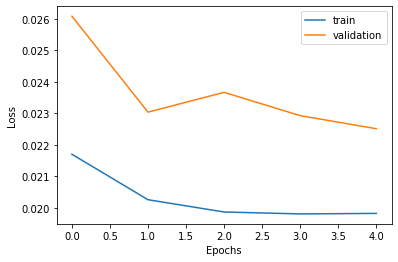

In [492]:
model, history = fit_lstm(x_train_scaled, 
                          y_train_scaled, 
                          batch=10, ep=5, 
                          neurons_lstm=5, 
                          neuron_dense=1
                         )

# Evaluate model

Forecast on test dataset by 1) forecasting with test dataset and 2)invert scaling. Also invert scaling on test dataset with actual demand.

In [493]:
def predictions(x_test_scaled, y_test):
    # get predictions
    test_pred = model.predict(x_test_scaled)
    
    # reverse transform predictions
    test_pred_inv = y_scaler.inverse_transform(test_pred)
    
    # create single dataframe with predictions (1) and expected values (2)
    predictions = np.concatenate((test_pred_inv, y_test), axis=1)
    predictions = pd.DataFrame(predictions)
    
    return predictions 

In [494]:
predictions = predictions(x_test_scaled, y_test)

In [495]:
def evaluate_lstm(predictions, start_val, end_val):
    # print RMSE
    rmse = np.sqrt(mean_squared_error(predictions[0], predictions[1]))
    print('Test RMSE: %.3f' % rmse)
    
    # print min max values of predictions and actual values.
    print("Min. value:", predictions[0].min())
    print("Max. value:", predictions[0].max())

    print("Min. value:", predictions[1].min())
    print("Max. value:", predictions[1].max())
    
    # plot predictions vs actual values
    plt.plot(predictions[0][start_val:end_val])
    plt.plot(predictions[1][start_val:end_val])
    
    return rmse

Test RMSE: 3.605
Min. value: -0.4192523658275604
Max. value: 8.670208930969238
Min. value: 0.0
Max. value: 20.0


3.6051227706283973

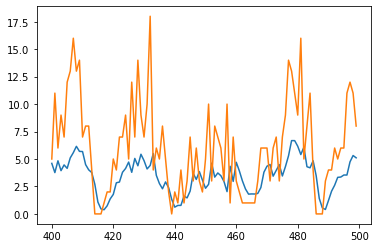

In [496]:
evaluate_lstm(predictions, start_val=400, end_val=500)

In [497]:
def check_min_max(ts1, ts2):
    if isinstance(ts1, pd.DataFrame) and isinstance(ts1, pd.DataFrame):
        print("Min value output value:", ts1.min())
        print("Max value input value:", ts1.max())
        print("Min value output value:", ts2.min())
        print("Max value ouput value:", ts2.max())
    elif isinstance(ts1, np.ndarray) and isinstance(ts2, np.ndarray):
        print("Min value input value:", np.min(ts1))
        print("Max value input value:", np.max(ts1))
        print("Min value output value:", np.min(ts2))
        print("Max value ouput value:", np.max(ts2))
    else:
        print("Error: not dataframe nor numpy array")

In [498]:
check_min_max(y_train, y_test)

Min value input value: 0
Max value input value: 23
Min value output value: 0
Max value ouput value: 20
